
## Sentiment Analysis using Bidirectional RNNs, 1D CNNs, and Language Models

In this notebook, we will continue working on our IMDb example, but this time we will develop three new models: a bidirectional recurrent model, a 1D convolutional model, and a model that combines both. Lastly, we develop a RNN model in which we use the pre-trained GloVe language model instead of learning embedding vectors from our own dataset.

## Using bidirectional RNNs

A bidirectional RNN is common RNN variant which can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing (NLP).

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or
reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason
why they perform well on problems where order is meaningful, such as the IMDb sentiment analysis example or the temperature forecasting problem. A bidirectional RNN exploits the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the LSTM layers that you are already familiar with,
each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By
processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Importantly, a RNN trained on reversed sequences will learn different representations than one trained on the original sequences, in much the same way that you would
have quite different mental models if time flowed backwards in the real world -- if you lived a life where you died on your first day and you were born on your last day. In machine learning, representations that are *different* yet *useful* are always worth exploiting, and the more they differ the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other
approaches, and thus they can allow to boost performance on a task. This is the intuition behind *ensembling*, a concept that we will cover later in the course (e.g., a random forest model is a collection or ensemble of decision trees).

A bidirectional RNN exploits this idea to improve upon the performance of chronological-order RNNs: it looks at its inputs sequence both ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

Let's try this idea on our IMDb example.

## Loading the data

Let's start by preparing the data. We will restrict the movie reviews to the top 10,000 most common words (like we did before), and cut the reviews after 100 words, or pad them to length 100, using the `pad_sequences` function below.


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Load the data as lists of integers
# We only keep the top 10,000 most frequently occurring words in the training data
# (Rare words will be discarded as before)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# Recall that our movie reviews have different lengths.
# The following turns our lists of integers into a 2D integer tensor of shape `(samples, maxlen=100)`
# In other words, for reviews shorter than 100 words, we add zeros to make the length=100;
# for reviews longer than 100 words, we cut them after 100 words. (100 is arbitrary!)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=100)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=100)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(25000, 100)

In [ ]:
x_test.shape

(25000, 100)

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by setting apart 10,000 samples from the original training data:

In [ ]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## A BLSTM model

We are now ready to develop a bidirectional recurrent model. We will use a Bidirectional Long Short-Term Memory (BLSTM) layer here.

To instantiate a bidirectional RNN in Keras, one would use the `Bidirectional` layer, which takes as first argument a recurrent layer instance. `Bidirectional` will create a second, separate instance of this recurrent layer, and will use one instance for processing the input sequences in chronological order and the other instance for processing the input sequences in reversed order.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [ ]:
model1 = models.Sequential()

model1.add(layers.Embedding(10000, 128, input_length=100))

model1.add(layers.Bidirectional(layers.LSTM(64)))

model1.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='rmsprop',  metrics=['accuracy'])

In [ ]:
model1_history = model1.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 70ms/step - loss: 0.6221 - accuracy: 0.6761 - val_loss: 0.4183 - val_accuracy: 0.8110
Epoch 2/20
30/30 [==============================] - 1s 44ms/step - loss: 0.3757 - accuracy: 0.8426 - val_loss: 0.3662 - val_accuracy: 0.8445
Epoch 3/20
30/30 [==============================] - 1s 44ms/step - loss: 0.3095 - accuracy: 0.8755 - val_loss: 0.3525 - val_accuracy: 0.8469
Epoch 4/20
30/30 [==============================] - 1s 44ms/step - loss: 0.2521 - accuracy: 0.9049 - val_loss: 0.3884 - val_accuracy: 0.8276
Epoch 5/20
30/30 [==============================] - 1s 44ms/step - loss: 0.2147 - accuracy: 0.9195 - val_loss: 0.4020 - val_accuracy: 0.8450
Epoch 6/20
30/30 [==============================] - 1s 44ms/step - loss: 0.2040 - accuracy: 0.9239 - val_loss: 0.3832 - val_accuracy: 0.8419
Epoch 7/20
30/30 [==============================] - 1s 44ms/step - loss: 0.1874 - accuracy: 0.9323 - val_loss: 0.4194 - val_accuracy: 0.8474
Epoch 8/20
30

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


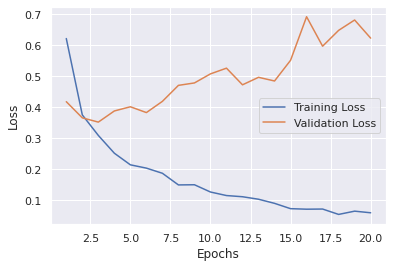

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc1  = model1_history.history['accuracy']
train_loss1 = model1_history.history['loss']
val_acc1  = model1_history.history['val_accuracy']
val_loss1 = model1_history.history['val_loss']

epochs = range(1, len(train_acc1) + 1)

plt.plot(epochs, train_loss1, label = 'Training Loss')
plt.plot(epochs, val_loss1, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

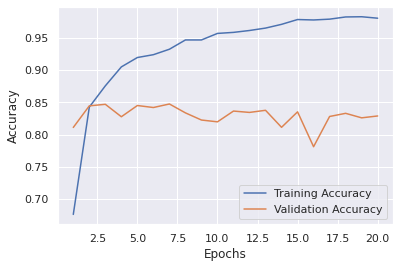

In [ ]:
plt.plot(epochs, train_acc1, label = 'Training Accuracy')
plt.plot(epochs, val_acc1, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# Evaluate the model on the test set
model1.evaluate(x_test, y_test)

782/782 [==============================] - 6s 7ms/step - loss: 0.6863 - accuracy: 0.8198


[0.6862687468528748, 0.8198000192642212]

Using the bidirectional LSTM layer, we achived an accuracy of almost 82%. By using recurrent dropout, we can fight overfitting and improve the model generalization.  

## Sequence processing with convnets: Implementing a 1D convnet

In Keras, you would use a 1D convnet via the `Conv1D` layer, which has a very similar interface to `Conv2D`. It takes as input 3D tensors
with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal
axis (axis 1) in the input tensor.

1D convnets consist of a stack of `Conv1D`
and `MaxPooling1D` layers, eventually ending in either a global pooling layer or a `Flatten` layer, turning the 3D outputs into 2D outputs (one vector of numbers for each sample), allowing to add one or more `Dense` layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would
only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

Let's build a simple 2-layer 1D convnet and apply it to the IMDb sentiment classification task that you are already familiar with.


In [ ]:
model2 = models.Sequential()
model2.add(layers.Embedding(10000, 128, input_length=100))

model2.add(layers.Conv1D(128, 7, activation='relu'))
model2.add(layers.MaxPooling1D(5))

model2.add(layers.Conv1D(128, 7, activation='relu'))
model2.add(layers.GlobalMaxPooling1D())

model2.add(layers.Dense(1, activation='sigmoid'))

In the above, we have 128 filters of size 7 in each convolutional layer, and we use the ReLU activation function. To read about other optional parameters in a Conv1D layer, please refer to the Keras [website](https://keras.io/api/layers/convolution_layers/convolution1d).

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 94, 128)           114816    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 128)           114816    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,509,761
Trainable params: 1,509,761
Non-trainable params: 0
____________________________________________

**Q)** Can you tell why we have 114816 parameters in the first Conv1D layer?

**A)** Note that each input sequence (review) has size 100 * 128 after embedding into a 128-dimensional space. Therefore, each filter has 7 * 128 weights and one bias. We have 128 filters. Therefore, we have 128 * (7 * 128 + 1) =  114816 learnable parameters.

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='rmsprop',  metrics=['accuracy'])

In [ ]:
model2_history = model2.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 43ms/step - loss: 0.6439 - accuracy: 0.6077 - val_loss: 0.5324 - val_accuracy: 0.7301
Epoch 2/20
30/30 [==============================] - 1s 38ms/step - loss: 0.4142 - accuracy: 0.8131 - val_loss: 0.4070 - val_accuracy: 0.8141
Epoch 3/20
30/30 [==============================] - 1s 37ms/step - loss: 0.3067 - accuracy: 0.8723 - val_loss: 0.4037 - val_accuracy: 0.8176
Epoch 4/20
30/30 [==============================] - 1s 38ms/step - loss: 0.2435 - accuracy: 0.9005 - val_loss: 0.4872 - val_accuracy: 0.8003
Epoch 5/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1996 - accuracy: 0.9258 - val_loss: 0.4688 - val_accuracy: 0.8113
Epoch 6/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1502 - accuracy: 0.9449 - val_loss: 0.5418 - val_accuracy: 0.8037
Epoch 7/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1219 - accuracy: 0.9557 - val_loss: 0.6692 - val_accuracy: 0.7778
Epoch 8/20
30

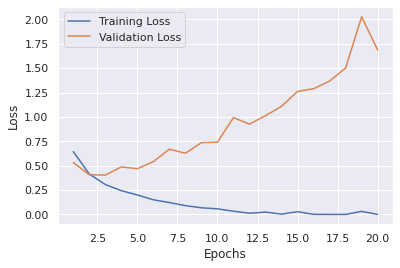

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc2  = model2_history.history['accuracy']
train_loss2 = model2_history.history['loss']
val_acc2  = model2_history.history['val_accuracy']
val_loss2 = model2_history.history['val_loss']

epochs = range(1, len(train_acc2) + 1)

plt.plot(epochs, train_loss2, label = 'Training Loss')
plt.plot(epochs, val_loss2, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

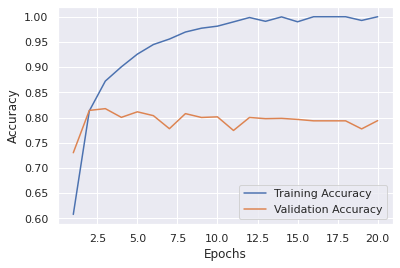

In [ ]:
plt.plot(epochs, train_acc2, label = 'Training Accuracy')
plt.plot(epochs, val_acc2, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# Evaluate the model on the test set
model2.evaluate(x_test, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 1.8374 - accuracy: 0.7802


[1.8374395370483398, 0.7801600098609924]

We achieved a test accuracy of 78%, which is not as good as the LSTM or BLSTM models.

## Combining CNNs and RNNs to process long sequences

Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps or words (beyond the size of the convolution windows), unlike RNNs.

One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing step before an RNN layer. This is especially beneficial when dealing with sequences that are so long that they couldn't realistically be processed
with RNNs, e.g. sequences with thousands of steps/words. The convnet will turn the long input sequence into much shorter (downsampled) sequences of higher-level features. This sequence of extracted features then becomes the input to the RNN part of the network.

Although our sequences are not very long in the IMDb example (recall that we took the first 100 words of each review), we are going to develop a model to combine CNNs and RNNs for demonstration purposes.

Below, I use a Conv1D layer with 128 filters and filter size 7 before a bidirectional LSTM layer with 64 units. I also use dropout and recurrent dropout in an attemp to fight overfitting.

In [ ]:
model3 = models.Sequential()
model3.add(layers.Embedding(10000, 128, input_length=100))

model3.add(layers.Conv1D(128, 7, activation='relu'))

model3.add(layers.Bidirectional(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.5)))

model3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='rmsprop',  metrics=['accuracy'])

In [ ]:
model3_history = model3.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 26s 883ms/step - loss: 0.5965 - accuracy: 0.6789 - val_loss: 0.4278 - val_accuracy: 0.8085
Epoch 2/20
30/30 [==============================] - 26s 876ms/step - loss: 0.3705 - accuracy: 0.8393 - val_loss: 0.3711 - val_accuracy: 0.8323
Epoch 3/20
30/30 [==============================] - 27s 887ms/step - loss: 0.2925 - accuracy: 0.8844 - val_loss: 0.4321 - val_accuracy: 0.8136
Epoch 4/20
30/30 [==============================] - 26s 880ms/step - loss: 0.2390 - accuracy: 0.9045 - val_loss: 0.3734 - val_accuracy: 0.8435
Epoch 5/20
30/30 [==============================] - 27s 895ms/step - loss: 0.2026 - accuracy: 0.9218 - val_loss: 0.5391 - val_accuracy: 0.8006
Epoch 6/20
30/30 [==============================] - 26s 880ms/step - loss: 0.1588 - accuracy: 0.9376 - val_loss: 0.3967 - val_accuracy: 0.8316
Epoch 7/20
30/30 [==============================] - 26s 876ms/step - loss: 0.1360 - accuracy: 0.9496 - val_loss: 0.4697 - val_accuracy: 0.8246

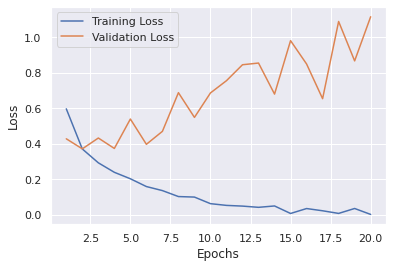

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc3  = model3_history.history['accuracy']
train_loss3 = model3_history.history['loss']
val_acc3  = model3_history.history['val_accuracy']
val_loss3 = model3_history.history['val_loss']

epochs = range(1, len(train_acc3) + 1)

plt.plot(epochs, train_loss3, label = 'Training Loss')
plt.plot(epochs, val_loss3, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

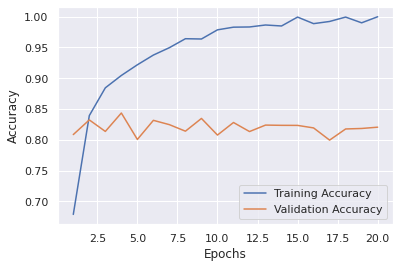

In [ ]:
plt.plot(epochs, train_acc3, label = 'Training Accuracy')
plt.plot(epochs, val_acc3, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# Evaluate the model on the test set
model3.evaluate(x_test, y_test)

782/782 [==============================] - 49s 62ms/step - loss: 1.0786 - accuracy: 0.8055


[1.0786283016204834, 0.8055199980735779]

## Using Pretrained Word Embeddings (Language Models)

The code below downloads a pretrained language model called the Global Vectors (GloVe).

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-10-06 00:22:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-06 00:22:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-06 00:22:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

The code block below is parsing the GloVe word-embeddings file. The output is the dictionary `embeddings_index` which stores the GloVe embeddings for each word. There are 400,000 word embedding vectors!

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Let's look at the embedding vector for the word 'hello'.

In [ ]:
embeddings_index.get('hello')

array([ 0.26688  ,  0.39632  ,  0.6169   , -0.77451  , -0.1039   ,
        0.26697  ,  0.2788   ,  0.30992  ,  0.0054685, -0.085256 ,
        0.73602  , -0.098432 ,  0.5479   , -0.030305 ,  0.33479  ,
        0.14094  , -0.0070003,  0.32569  ,  0.22902  ,  0.46557  ,
       -0.19531  ,  0.37491  , -0.7139   , -0.51775  ,  0.77039  ,
        1.0881   , -0.66011  , -0.16234  ,  0.9119   ,  0.21046  ,
        0.047494 ,  1.0019   ,  1.1133   ,  0.70094  , -0.08696  ,
        0.47571  ,  0.1636   , -0.44469  ,  0.4469   , -0.93817  ,
        0.013101 ,  0.085964 , -0.67456  ,  0.49662  , -0.037827 ,
       -0.11038  , -0.28612  ,  0.074606 , -0.31527  , -0.093774 ,
       -0.57069  ,  0.66865  ,  0.45307  , -0.34154  , -0.7166   ,
       -0.75273  ,  0.075212 ,  0.57903  , -0.1191   , -0.11379  ,
       -0.10026  ,  0.71341  , -1.1574   , -0.74026  ,  0.40452  ,
        0.18023  ,  0.21449  ,  0.37638  ,  0.11239  , -0.53639  ,
       -0.025092 ,  0.31886  , -0.25013  , -0.63283  , -0.0118

Below, we prepare the GloVe word-embeddings matrix. For each unique word in the IMDb dataset, we read the corresponding embedding vector from the GloVe dictionary and store it in a large matrix called `embedding_matrix`.

In [ ]:
#from tensorflow.keras.layers import TextVectorization
#text_vectorization = TextVectorization(output_mode="int")

embedding_dim = 100 #we loaded glove.6B.100d above
max_tokens = 88584 #this is the number of unique words in the imdb dataset

vocabulary = imdb.get_word_index()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

#Prepare a matrix that we’ll fill with the GloVe vectors
embedding_matrix = np.zeros((max_tokens, embedding_dim))

#Fill entry i in the matrix with the word vector for index i
#Words not found in the embedding index will be all zeros
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
word_index.get('hello')


78549

For example, let's look at the word embedding for index 78549, which correcponds to the word 'hello'.

In [ ]:
embedding_matrix[78549]

array([ 0.26688001,  0.39631999,  0.61690003, -0.77451003, -0.1039    ,
        0.26697001,  0.27880001,  0.30992001,  0.0054685 , -0.085256  ,
        0.73602003, -0.098432  ,  0.54790002, -0.030305  ,  0.33478999,
        0.14094   , -0.0070003 ,  0.32569   ,  0.22902   ,  0.46557   ,
       -0.19531   ,  0.37491   , -0.71390003, -0.51775002,  0.77038997,
        1.08809996, -0.66011   , -0.16234   ,  0.91189998,  0.21046001,
        0.047494  ,  1.00189996,  1.11329997,  0.70094001, -0.08696   ,
        0.47571   ,  0.1636    , -0.44468999,  0.44690001, -0.93817002,
        0.013101  ,  0.085964  , -0.67456001,  0.49662   , -0.037827  ,
       -0.11038   , -0.28612   ,  0.074606  , -0.31527001, -0.093774  ,
       -0.57068998,  0.66864997,  0.45307001, -0.34154001, -0.7166    ,
       -0.75273001,  0.075212  ,  0.57902998, -0.1191    , -0.11379   ,
       -0.10026   ,  0.71341002, -1.15740001, -0.74026   ,  0.40452   ,
        0.18023001,  0.21449   ,  0.37638   ,  0.11239   , -0.53

Below, we use a Constant initializer to load the pretrained embeddings in an Embedding layer. So as not to disrupt the pretrained representations during training, we freeze the layer via `trainable=False`.

In [ ]:
from tensorflow.keras import initializers

model4 = models.Sequential()

model4.add(layers.Embedding(max_tokens, embedding_dim, input_length=100, mask_zero=True,
                            embeddings_initializer=initializers.Constant(embedding_matrix),
                            trainable=False))

model4.add(layers.Bidirectional(layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3)))

model4.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          8858400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,892,513
Trainable params: 34,113
Non-trainable params: 8,858,400
_________________________________________________________________


Note above that because we froze the embedding layer, all of its parameters are non-trainable.

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'])

In [ ]:
model4_history = model4.fit(partial_x_train,
                            partial_y_train,
                            epochs=50,
                            batch_size=256,
                            validation_data=(x_val, y_val))

Epoch 1/50
59/59 [==============================] - 58s 898ms/step - loss: 0.6921 - accuracy: 0.5213 - val_loss: 0.6808 - val_accuracy: 0.5697
Epoch 2/50
59/59 [==============================] - 51s 870ms/step - loss: 0.6681 - accuracy: 0.5904 - val_loss: 0.6263 - val_accuracy: 0.6456
Epoch 3/50
59/59 [==============================] - 51s 869ms/step - loss: 0.6297 - accuracy: 0.6488 - val_loss: 0.6119 - val_accuracy: 0.6705
Epoch 4/50
59/59 [==============================] - 52s 878ms/step - loss: 0.6020 - accuracy: 0.6779 - val_loss: 0.5756 - val_accuracy: 0.7012
Epoch 5/50
59/59 [==============================] - 51s 863ms/step - loss: 0.5884 - accuracy: 0.6876 - val_loss: 0.5756 - val_accuracy: 0.7062
Epoch 6/50
59/59 [==============================] - 51s 871ms/step - loss: 0.5686 - accuracy: 0.7058 - val_loss: 0.5653 - val_accuracy: 0.7091
Epoch 7/50
59/59 [==============================] - 52s 883ms/step - loss: 0.5487 - accuracy: 0.7223 - val_loss: 0.5908 - val_accuracy: 0.7121

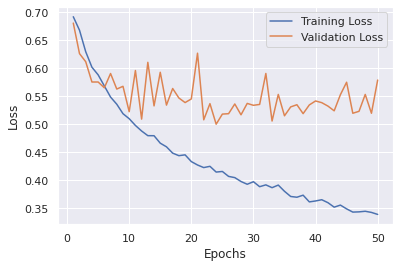

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc4  = model4_history.history['accuracy']
train_loss4 = model4_history.history['loss']
val_acc4  = model4_history.history['val_accuracy']
val_loss4 = model4_history.history['val_loss']

epochs = range(1, len(train_acc4) + 1)

plt.plot(epochs, train_loss4, label = 'Training Loss')
plt.plot(epochs, val_loss4, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Evaluate the model on the test set
model4.evaluate(x_test, y_test)

782/782 [==============================] - 48s 61ms/step - loss: 0.5870 - accuracy: 0.7928


[0.5869691967964172, 0.7928400039672852]

We see that using the GloVe language model, we achieved 79.3% accuracy on the test dataset.

## Wrapping up

Here's what you should take away from this section:

* In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing temporal patterns. They offer a faster alternative to RNNs on some problems, in particular NLP tasks.

* Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of `Conv1D` layers and `MaxPooling1D` layers, eventually ending in a global pooling operation or flattening operation.

* Because RNNs are extremely expensive for processing very long sequences, but 1D convnets are cheap, it can be a good idea to use a 1D convnet as a preprocessing step before an RNN, shortening the sequence and extracting useful representations for the RNN to process.

* Instead of learning word embeddings from our own data, usually it is a better idea to use pre-trained language models, which can quickly return an embedding vector for each word in the dictionary.
